# All PREPARE

## IMPORT Data and libraries

In [43]:
import pandas as pd 
import numpy as np
from pathlib import Path
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
from normalize_data import (
    df_budget,
    df_trp,

    df_upload as df_upload_raw
)

In [56]:
# Группировка 'telecomp' & 'month'
df_group_upload= (
    df_upload_raw[['telecomp','TVR','month']]
    .groupby(['telecomp','month'])
    .agg(sum).reset_index()
    )

In [5]:
# Объединение и преобразование unpivot
melted_df1 = pd.melt(df_trp, id_vars='telecomp', var_name='month', value_name='plan')


melted_df1['telecomp'] = melted_df1['telecomp'].str.upper()

melted_df1 = melted_df1.query('month !="Все месяцы"')

# Аналитика

## Tasks 1
 - [x] Задача: понять, выполняется ли в каждой кампании плановый объём TRP
    - general_rating рейтинг = 6
 - [x] Задача: по всем кампаниям
    - rating_each_company
    - rating_analog
    - [x] каналов дистрибъюции 1 == Сетевой : 3966
      - df_upload_raw.distribution_ch.value_counts()

In [8]:
def calculate_rating(deviation):
    if deviation > 5:
        rating = 10
    elif deviation == 0:
        rating = 8
    else:
        rating = 1 + (deviation / 5) * 7 
    return round(rating,2)

In [6]:
def make_compare_fact_plan_df(
    group_by_value,
    ):
    df_compare=(
        pd.merge(melted_df1,df_group_upload,on=['telecomp','month'])
        .groupby(group_by_value).agg(
            plan=('plan','sum'),
            fact=('TVR','sum')).reset_index()
        )
    df_compare[['fact','plan']] = df_compare[['fact','plan']].apply(pd.to_numeric)
    df_compare['TVR_deviation'] = (df_compare['fact'] - df_compare['plan']) / df_compare['plan'] * 100


    return df_compare


,company,rating_
0,1,10.00
1,3,5.70
2,5,10.00
3,7,-5.14
4,9,5.39
5,11,-2.91


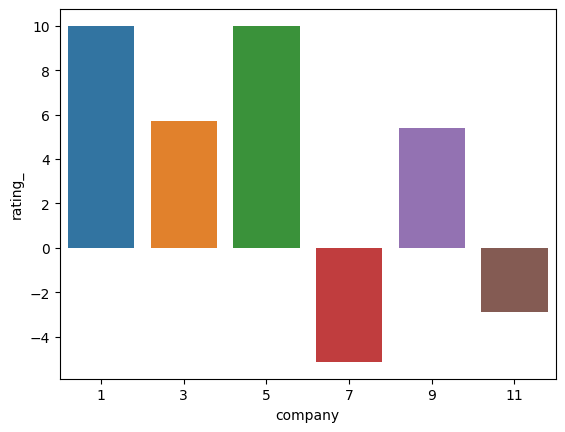

In [10]:

df_compare = make_compare_fact_plan_df(['month'])

df_compare['rating_'] = df_compare['TVR_deviation'].apply(calculate_rating)

df_compare= df_compare.rename(columns={'month':"company"})
group_by_company = df_compare[['company','rating_']]
sns.barplot(data=group_by_company,x='company',y='rating_')
group_by_company

<Axes: xlabel='company', ylabel='rating_'>

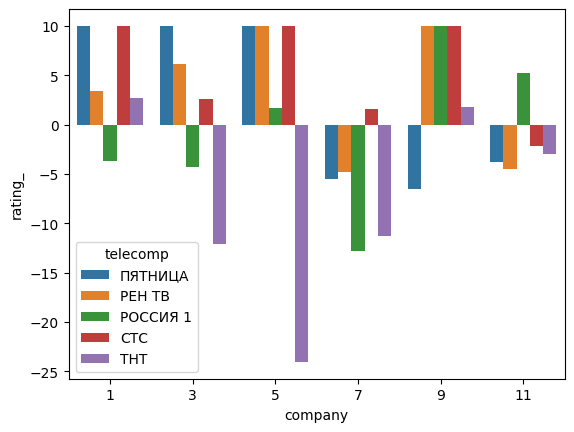

In [17]:

by_company= make_compare_fact_plan_df(group_by_value=["month",'telecomp',])[['month',"TVR_deviation",'telecomp','fact','plan']]
by_company['rating_'] = by_company['TVR_deviation'].apply(calculate_rating)

by_company = by_company.rename(columns={"month":"company"})
by_company.sort_values(by='company',ascending=True)
by_company
sns.barplot(data=by_company,x='company',y='rating_',hue="telecomp")


<Axes: xlabel='company', ylabel='TVR_deviation'>

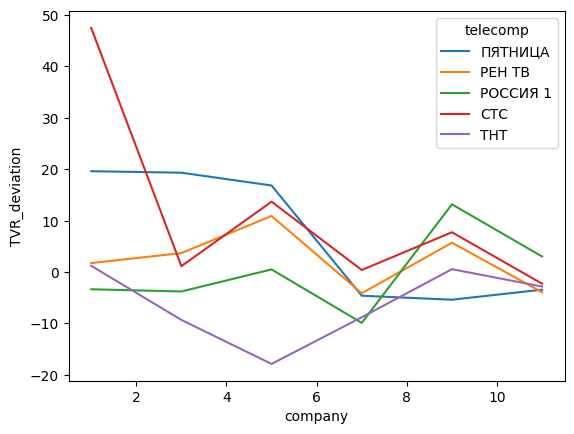

In [18]:
sns.lineplot(data=by_company.sort_values(by='company'),x='company',y='TVR_deviation',hue='telecomp')

<Axes: xlabel='telecomp', ylabel='value'>

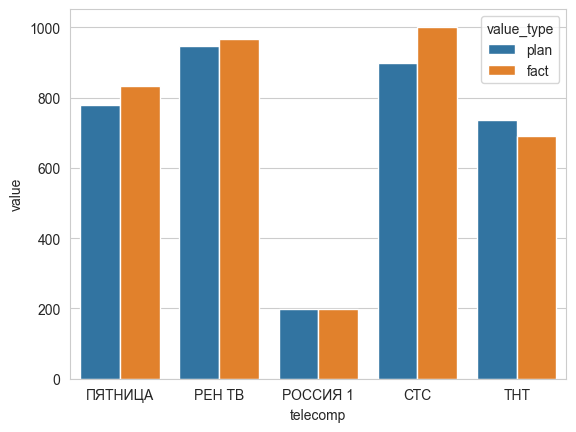

In [55]:

df_audience= by_company.groupby(
    'telecomp',as_index=False).agg(
        plan=("plan",'sum'),
        fact=("fact",'sum'))
df_audience_melted = df_audience.melt(id_vars='telecomp', value_vars=['plan', 'fact'], var_name='value_type', value_name='value')

df_audience_melted
sns.barplot(
    data=df_audience_melted,
    y="value",
    x="telecomp",
    hue='value_type'
    )

In [12]:

totals = df_compare.sum(numeric_only=True)

totals['telecomp'] = 'Итого'
df_compare = pd.concat([df_compare, pd.DataFrame(totals).T], ignore_index=True)    


df_compare[['fact','plan']] = df_compare[['fact','plan']].apply(pd.to_numeric)
df_compare['TVR_deviation'] = (df_compare['fact'] - df_compare['plan']) / df_compare['plan'] * 100
df_compare

categories = [-float('inf'),-10,-5,0,5,10, float('inf')]
ratings = [0, 2, 4, 6, 8,10]

df_compare = df_compare[['telecomp','plan','fact','TVR_deviation']]

df_compare['client_rating'] = pd.cut(df_compare['TVR_deviation'], bins=categories, labels=ratings)

customer_rating = df_compare[['telecomp','client_rating']].rename(columns={'TVR_deviation':'customer_rating'})
general_rating = customer_rating.iloc[-1,:]

general_rating

telecomp         Итого
client_rating        6
Name: 6, dtype: object

# Рейтинг компаний друг относительно друга
## 1. quantile

In [ ]:
# by every month quanilte
df = df_compare
q10 = df['TVR_deviation'].quantile(0.1)
q90 = df['TVR_deviation'].quantile(0.9)

df['rating_by_distribute'] = np.where(df['TVR_deviation'] < q10, 0, np.where(df['TVR_deviation'] > q90, 10, ((df['TVR_deviation'] - q10) / (q90 - q10)) * 10))

# Rounding ratings to nearest integer
df['rating_by_distribute'] = df['rating_by_distribute'].round().astype(int)
rating_analog = df[['telecomp',"TVR_deviation","client_rating",'rating_by_distribute']]
rating_analog

# Plotly

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots